# **Final Project Task 5 - Census Modeling NN Regression**

Requirements

- Create a NN regression model on the Census dataset, with 'hours-per-week' target

- Model Selection and Setup:
    - Build a neural network model using a deep learning library like TensorFlow, Keras or PyTorch.
    - Choose a loss (or experiment with different losses) for the model and justify the choice.
        - MSE, MAE, RMSE, Huber Loss or others
    - Justify model choices based on dataset characteristics and task requirements; specify model pros and cons.


- Data Preparation
    - Use the preprocessed datasets from Task 1.
    - From the train set, create an extra validation set, if necesarry. So in total there will be: train, validation and test datasets.
    - Be sure all models have their data preprocessed as needed. Some models require different, or no encoding for some features.


- Model Training and Experimentation
    - Establish a Baseline Model:
        - Train a simple NN model with default settings as a baseline.
        - Evaluate its performance to establish a benchmark for comparison.
    - Make plots with train, validation loss and metric on epochs (or on steps), if applicable.
    - Feature Selection:
        - Neural Networks can learn feature importance automatically, so all relevant features should be included rather than manually selecting a subset.
        - Consider using embeddings for high-cardinality categorical features instead of one-hot encoding to improve efficiency.
    - Experimentation:
        - Focus on preprocessing techniques rather than manually selecting feature combinations. Ensure numerical features are normalized (e.g., MinMaxScaler, StandardScaler) and categorical features are properly encoded (e.g., one-hot encoding or embeddings for high-cardinality variables).
        - Experiment with different neural network architectures (e.g., number of layers, neurons per layer) and hyperparameters (e.g., activation functions, learning rates, dropout rates, and batch sizes).
        - Use techniques such as early stopping and learning rate scheduling to optimize model performance and prevent overfitting.
        - Identify the best model which have the best performance metrics on test set.
    - Hyperparameter Tuning:
        - Perform hyperparameter tuning only on the best-performing model after evaluating all model types and experiments.
        - Consider using techniques like Grid Search for exhaustive tuning, Random Search for quicker exploration, or Bayesian Optimization for an intelligent, efficient search of hyperparameters.
        - Avoid tuning models that do not show strong baseline performance or are unlikely to outperform others based on experimentation.
        - Ensure that hyperparameter tuning is done after completing feature selection, baseline modeling, and experimentation, ensuring that the model is stable and representative of the dataset.


- Model Evaluation
    - Evaluate models on the test dataset using regression metrics:
        - Mean Absolute Error (MAE)
        - Mean Squared Error (MSE)
        - Root Mean Squared Error (RMSE)
        - R² Score
    - Choose one metric for model comparison and explain your choice
    - Compare the results across different models. Save all experiment results into a table.



Deliverables

- Notebook code with no errors.
- Code and results from experiments. Create a table with all experiments results, include experiment name, metrics results.
- Explain findings, choices, results.
- Potential areas for improvement or further exploration.


In [1]:
import pandas as pd

In [2]:
data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
columns = [
    "age", "workclass", "fnlwgt", "education", "education-num", "marital-status",
    "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss",
    "hours-per-week", "native-country", "income"
]

data = pd.read_csv(data_url, header=None, names=columns, na_values=" ?", skipinitialspace=True)
data.sample(10)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
1150,25,Private,241626,HS-grad,9,Never-married,Other-service,Own-child,White,Male,0,0,30,United-States,<=50K
28206,32,?,377017,Assoc-acdm,12,Never-married,?,Own-child,White,Male,0,0,40,United-States,<=50K
26330,35,Self-emp-not-inc,160192,Some-college,10,Never-married,Craft-repair,Own-child,White,Male,0,0,40,United-States,<=50K
9367,17,?,406920,10th,6,Never-married,?,Own-child,White,Male,0,0,40,United-States,<=50K
8863,30,Private,242460,HS-grad,9,Separated,Craft-repair,Not-in-family,White,Male,0,0,50,United-States,<=50K
949,44,Self-emp-not-inc,325159,Some-college,10,Divorced,Farming-fishing,Unmarried,White,Male,0,0,40,United-States,<=50K
3944,43,Private,421837,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,Mexico,<=50K
1707,32,?,158784,7th-8th,4,Widowed,?,Not-in-family,White,Female,0,0,40,United-States,<=50K
12212,45,Local-gov,140644,Bachelors,13,Divorced,Protective-serv,Not-in-family,White,Male,0,0,40,United-States,>50K
6748,81,Private,122651,Some-college,10,Married-civ-spouse,Sales,Husband,White,Male,0,0,15,United-States,<=50K


Celula 1 — Importuri (TensorFlow + utilitare)

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader


Celula 1 importă toate librăriile necesare pentru manipularea datelor, antrenarea și evaluarea unui model de regresie bazat pe rețele neuronale în PyTorch, precum și pentru vizualizarea procesului de antrenare și calculul metricilor cerute.


Celula 2 — Setări + device (CPU/GPU)

In [4]:
np.random.seed(42)
torch.manual_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cpu


De ce? Reproducibilitate + folosim GPU dacă există (altfel CPU e ok).

Celula 3 — Load data preprocesat (Task 1) + split train/val/test
Varianta A (recomandat): ai train/test deja salvate

In [5]:
target = "hours-per-week"

train_df = pd.read_csv("adult_preprocessed_train.csv")
test_df  = pd.read_csv("adult_preprocessed_test.csv")

X_train_full = train_df.drop(columns=[target]).values.astype(np.float32)
y_train_full = train_df[target].values.astype(np.float32)

X_test = test_df.drop(columns=[target]).values.astype(np.float32)
y_test = test_df[target].values.astype(np.float32)

# Train/Val split (din train)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42
)

X_train.shape, X_val.shape, X_test.shape


((20823, 99), (5206, 99), (6508, 99))

In [ ]:
# full_df = pd.read_csv("adult_preprocessed_full.csv")
# target = "hours-per-week"
# X = full_df.drop(columns=[target]).values.astype(np.float32)
# y = full_df[target].values.astype(np.float32)
# X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)


Avem acum train + validation + test, cum cere task-ul.

Celula 4 — DataLoader (mini-batches)

In [6]:
batch_size = 256

train_ds = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train).unsqueeze(1))
val_ds   = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val).unsqueeze(1))
test_ds  = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test).unsqueeze(1))

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

len(train_loader), len(val_loader)


(82, 21)

De ce? NN se antrenează eficient pe batch-uri, nu pe tot setul o dată.

Celula 5 — Model NN (baseline)

In [7]:
class MLPRegressor(nn.Module):
    def __init__(self, input_dim, hidden_layers=[128, 64], dropout=0.0):
        super().__init__()
        layers_list = []
        prev = input_dim
        
        for h in hidden_layers:
            layers_list.append(nn.Linear(prev, h))
            layers_list.append(nn.ReLU())
            if dropout > 0:
                layers_list.append(nn.Dropout(dropout))
            prev = h
        
        layers_list.append(nn.Linear(prev, 1))  # output scalar
        
        self.net = nn.Sequential(*layers_list)
        
    def forward(self, x):
        return self.net(x)


De ce? MLP simplu (Dense + ReLU) e baseline corect pentru regresie pe date tabulare.

Celula 6 — Funcții training + evaluare + plot

In [8]:
def train_one_epoch(model, loader, optimizer, loss_fn):
    model.train()
    running_loss = 0.0
    
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        
        optimizer.zero_grad()
        preds = model(xb)
        loss = loss_fn(preds, yb)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * xb.size(0)
        
    return running_loss / len(loader.dataset)


@torch.no_grad()
def eval_one_epoch(model, loader, loss_fn):
    model.eval()
    running_loss = 0.0
    
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        loss = loss_fn(preds, yb)
        running_loss += loss.item() * xb.size(0)
        
    return running_loss / len(loader.dataset)


def fit_model(model, train_loader, val_loader, optimizer, loss_fn, epochs=50, patience=5):
    history = {"train_loss": [], "val_loss": []}
    best_val = float("inf")
    best_state = None
    bad_epochs = 0
    
    for epoch in range(1, epochs + 1):
        tr_loss = train_one_epoch(model, train_loader, optimizer, loss_fn)
        va_loss = eval_one_epoch(model, val_loader, loss_fn)
        
        history["train_loss"].append(tr_loss)
        history["val_loss"].append(va_loss)
        
        if va_loss < best_val:
            best_val = va_loss
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            bad_epochs = 0
        else:
            bad_epochs += 1
        
        if epoch % 5 == 0 or epoch == 1:
            print(f"Epoch {epoch:03d} | train_loss={tr_loss:.4f} | val_loss={va_loss:.4f}")
        
        if bad_epochs >= patience:
            print(f"Early stopping at epoch {epoch}. Best val_loss={best_val:.4f}")
            break
    
    if best_state is not None:
        model.load_state_dict(best_state)
    
    return history


def plot_history(history, title):
    plt.figure(figsize=(8,4))
    plt.plot(history["train_loss"], label="train_loss")
    plt.plot(history["val_loss"], label="val_loss")
    plt.title(title)
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend()
    plt.show()


@torch.no_grad()
def predict(model, X_np):
    model.eval()
    X_t = torch.from_numpy(X_np).to(device)
    preds = model(X_t).cpu().numpy().reshape(-1)
    return preds


def regression_metrics(y_true, y_pred):
    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "MSE": mean_squared_error(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "R2": r2_score(y_true, y_pred)
    }


De ce?

păstrăm loss train/val pentru plot (cerință)

early stopping pentru a preveni overfitting

evaluare finală cu metricile cerute

Baseline Model (CERINȚĂ)
 Celula 7 — Baseline: MSE loss + Adam

Epoch 001 | train_loss=961.3618 | val_loss=137.4238
Epoch 005 | train_loss=117.1902 | val_loss=116.0426
Epoch 010 | train_loss=115.4646 | val_loss=115.4301
Epoch 015 | train_loss=113.8386 | val_loss=114.3166
Epoch 020 | train_loss=112.2557 | val_loss=114.4045
Epoch 025 | train_loss=111.3647 | val_loss=114.7289
Epoch 030 | train_loss=110.4753 | val_loss=113.0770
Epoch 035 | train_loss=109.6995 | val_loss=113.0395
Early stopping at epoch 35. Best val_loss=112.6561


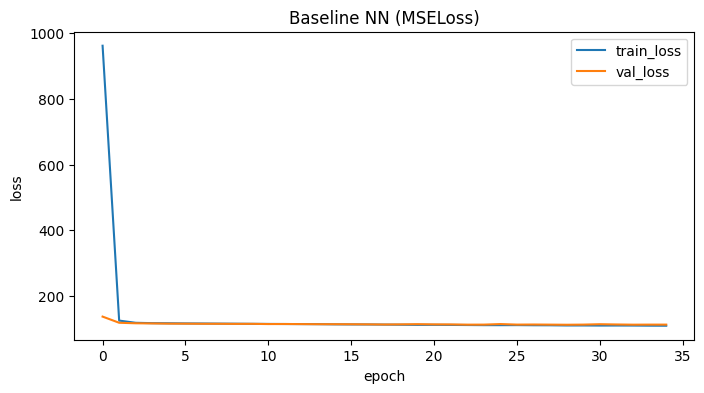

{'MAE': 7.381408214569092,
 'MSE': 114.56156158447266,
 'RMSE': np.float64(10.703343476898826),
 'R2': 0.2510327100753784}

In [9]:
input_dim = X_train.shape[1]

baseline = MLPRegressor(input_dim, hidden_layers=[128, 64], dropout=0.0).to(device)

loss_fn = nn.MSELoss()                 # justificare: standard pentru regresie
optimizer = torch.optim.Adam(baseline.parameters(), lr=1e-3)

hist_base = fit_model(baseline, train_loader, val_loader, optimizer, loss_fn, epochs=60, patience=6)
plot_history(hist_base, "Baseline NN (MSELoss)")

pred_test_base = predict(baseline, X_test)
base_metrics = regression_metrics(y_test, pred_test_base)
base_metrics


MSE penalizează mai puternic erorile mari; potrivit pentru regresie.

Adam converge rapid pe date tabulare.

Experimente (CERINȚĂ)

Facem 2 experimente clasice: Dropout și HuberLoss.

Celula 8 — Experiment 1: model mai mare + Dropout

Epoch 001 | train_loss=696.7659 | val_loss=123.0377
Epoch 005 | train_loss=136.7045 | val_loss=115.8674
Epoch 010 | train_loss=133.9919 | val_loss=114.6262
Epoch 015 | train_loss=132.1480 | val_loss=114.2880
Epoch 020 | train_loss=131.2368 | val_loss=113.5571
Epoch 025 | train_loss=129.8770 | val_loss=113.2198
Early stopping at epoch 27. Best val_loss=112.6988


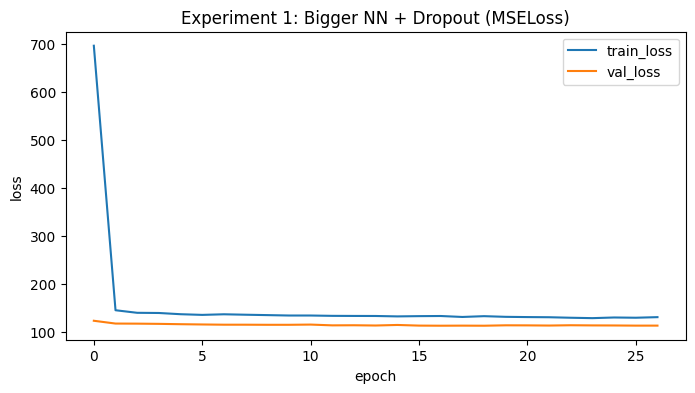

{'MAE': 7.389248847961426,
 'MSE': 114.43959045410156,
 'RMSE': np.float64(10.697644154396873),
 'R2': 0.2518300414085388}

In [10]:
exp1 = MLPRegressor(input_dim, hidden_layers=[256, 128, 64], dropout=0.2).to(device)

loss_fn1 = nn.MSELoss()
optimizer1 = torch.optim.Adam(exp1.parameters(), lr=1e-3)

hist_exp1 = fit_model(exp1, train_loader, val_loader, optimizer1, loss_fn1, epochs=80, patience=8)
plot_history(hist_exp1, "Experiment 1: Bigger NN + Dropout (MSELoss)")

pred_test_exp1 = predict(exp1, X_test)
exp1_metrics = regression_metrics(y_test, pred_test_exp1)
exp1_metrics


De ce? Dropout reduce overfitting când ai multe feature-uri one-hot.

Celula 9 — Experiment 2: Huber loss (SmoothL1) + dropout mic

În PyTorch, Huber = SmoothL1Loss.

Epoch 001 | train_loss=26.1547 | val_loss=7.3428
Epoch 005 | train_loss=7.2812 | val_loss=6.7992
Epoch 010 | train_loss=7.2431 | val_loss=6.7562
Epoch 015 | train_loss=7.2067 | val_loss=6.6889
Epoch 020 | train_loss=7.1529 | val_loss=6.6803
Epoch 025 | train_loss=7.1274 | val_loss=6.6589
Epoch 030 | train_loss=7.1077 | val_loss=6.6714
Epoch 035 | train_loss=7.0759 | val_loss=6.6249
Epoch 040 | train_loss=7.0922 | val_loss=6.6367
Epoch 045 | train_loss=7.0603 | val_loss=6.6579
Epoch 050 | train_loss=7.0642 | val_loss=6.6198
Epoch 055 | train_loss=7.0587 | val_loss=6.6090
Early stopping at epoch 56. Best val_loss=6.6059


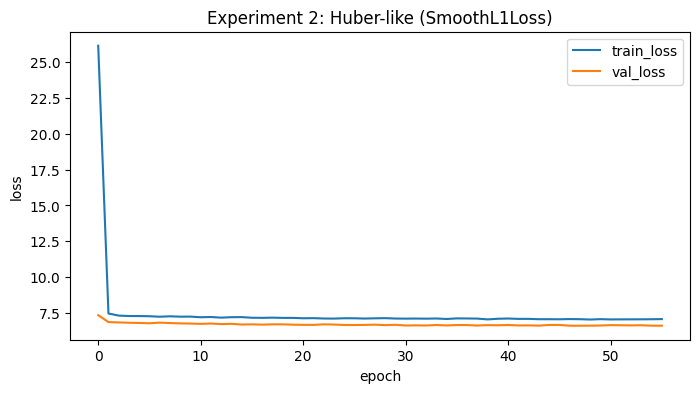

{'MAE': 7.084072589874268,
 'MSE': 117.6953353881836,
 'RMSE': np.float64(10.848748102347274),
 'R2': 0.2305450439453125}

In [11]:
exp2 = MLPRegressor(input_dim, hidden_layers=[128, 64], dropout=0.1).to(device)

loss_fn2 = nn.SmoothL1Loss()   # Huber-like, robust la outlieri
optimizer2 = torch.optim.Adam(exp2.parameters(), lr=1e-3)

hist_exp2 = fit_model(exp2, train_loader, val_loader, optimizer2, loss_fn2, epochs=80, patience=8)
plot_history(hist_exp2, "Experiment 2: Huber-like (SmoothL1Loss)")

pred_test_exp2 = predict(exp2, X_test)
exp2_metrics = regression_metrics(y_test, pred_test_exp2)
exp2_metrics


De ce Huber? e mai stabil decât MSE când există valori extreme ale targetului (ex: 80–99 ore).

Tabel rezultate (CERINȚĂ)
 Celula 10 — Comparare experimente

In [12]:
results = pd.DataFrame([
    {"experiment": "baseline_mse", **base_metrics},
    {"experiment": "exp1_dropout_mse", **exp1_metrics},
    {"experiment": "exp2_huber", **exp2_metrics}
]).set_index("experiment")

results


,MAE,MSE,RMSE,R2
experiment,,,,
baseline_mse,7.381408,114.561562,10.703343,0.251033
exp1_dropout_mse,7.389249,114.439590,10.697644,0.251830
exp2_huber,7.084073,117.695335,10.848748,0.230545


Celula 11 — Alege metrica principală (RMSE) + best model

In [13]:
best_exp = results["RMSE"].idxmin()
print("Best by RMSE:", best_exp)
results.loc[best_exp]


Best by RMSE: exp1_dropout_mse


MAE       7.389249
MSE     114.439590
RMSE     10.697644
R2        0.251830
Name: exp1_dropout_mse, dtype: float64

Aleg RMSE deoarece e în unitatea targetului (ore) și penalizează erorile mari.

Markdown: concluzii 
 Celula 12 — Summary Report (Markdown)

Task 5 – Neural Network Regression (PyTorch) – hours-per-week

Am folosit datele preprocesate din Task 1 (encoding + normalizare), apoi am creat split train/validation/test.

Baseline NN: MLP simplu (Dense + ReLU) cu loss MSE, optimizator Adam și early stopping, ca referință.

Experimente:

Arhitectură mai mare + Dropout pentru regularizare și reducerea overfitting-ului.

Huber-like loss (SmoothL1Loss) pentru robustețe la outlieri, deoarece distribuția hours-per-week are valori extreme.

Evaluare: Am calculat MAE, MSE, RMSE și R² pe test. Am ales RMSE ca metrică principală pentru comparație.

Concluzie: Cel mai bun model conform RMSE este {best_exp}. Pentru îmbunătățiri: tuning lr, batch_size, schedule lr și embeddings (în loc de one-hot) pentru categorice.